## Import Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from annoy import AnnoyIndex
import os

## Download the Data

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


## Exploratory Data Analysis

In [0]:
# resize the pixel values between 0 and 255
train_images = train_images/255
test_images = test_images/255

In [4]:
print(train_images.shape)
print(test_images.shape)

(60000, 28, 28)
(10000, 28, 28)


In [0]:
# different product categories in the dataset 
labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [6]:
# no of times each product category is present in the dataset
category_counts = dict(zip(*np.unique(train_labels, return_counts=True)))
print(category_counts)


{0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


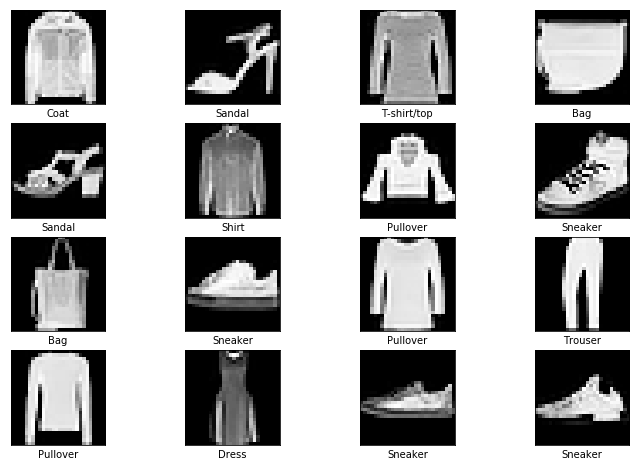

In [7]:
# let's show some sample images
plt.figure(figsize=(12,8))
for index in range(16):
  rand_idx = np.random.randint(0,train_labels.shape[0])
  plt.subplot(4,4,index+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')
  plt.imshow(train_images[rand_idx], cmap='Greys_r')
  plt.xlabel(labeldict[train_labels[rand_idx]])


## Helper Functions

Plot the original and the reconstructed image

In [0]:
def plot_images(original, reconstructed):
  
  fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(12,4))
  
  for images, axes in zip([original, reconstructed], axes):
    for image, ax in zip(images, axes):
      ax.imshow(image.reshape(28,28), cmap="Greys_r")
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
  fig.tight_layout(pad=0.1)

## Define the placeholders

In [0]:
# defines the placeholders for the inputs and the targets
# in this case the inputs and the targets are the same
def placeholders(image_size, n_channels ):
  inputs = tf.placeholder(dtype=tf.float32, shape=[None, image_size, image_size,n_channels], name='inputs')
  targets = tf.placeholder(dtype=tf.float32, shape=[None, image_size, image_size, n_channels], name='targets')
  batch_size = tf.placeholder(dtype=tf.int32, name='batch_size')
  return inputs, targets, batch_size

## Define the model

In [0]:
def encoder_decoder_network(X):
  
  #ENCODER NETOWRK
  
  # X's shape - 28*28*1
  W1 = tf.get_variable("W1", shape=[3,3,1,16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  # 28*28*16 
  conv1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='SAME')
  relu1 = tf.nn.relu(conv1)
  #14*14*16
  pool1 = tf.nn.max_pool(relu1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
  
  #14*14*8
  W2 = tf.get_variable("W2", shape=[3,3,16,8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  conv2 = tf.nn.conv2d(pool1, W2, strides=[1,1,1,1], padding='SAME')
  relu2 = tf.nn.relu(conv2)
  #7*7*8
  pool2 = tf.nn.max_pool(relu2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
  #7*7*8
  W3 = tf.get_variable("W3", shape=[3,3,8,8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  conv3 = tf.nn.conv2d(pool2, W3, strides=[1,1,1,1], padding='SAME')
  relu3 = tf.nn.relu(conv3)
  #4*4*8
  pool3 = tf.nn.max_pool(relu3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME', name='encodings')
  
  encoded = pool3
  
  # the image is now 4*4*8 
  
  # DECODER NETWORK 
  
  
  upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
  #7*7*8
  W4 = tf.get_variable("W4", shape=[3,3,8,8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  conv4 = tf.nn.conv2d(upsample1, W4, strides=[1,1,1,1], padding='SAME')
  relu4 = tf.nn.relu(conv4)
  
  upsample2 = tf.image.resize_nearest_neighbor(relu4, (14,14))
  # 14*14*8
  W5 = tf.get_variable("W5", shape=[3,3,8,8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  conv5 = tf.nn.conv2d(upsample2, W5, strides=[1,1,1,1], padding='SAME')
  relu5 = tf.nn.relu(conv5)
  
  # 28*28*8
  upsample3 = tf.image.resize_nearest_neighbor(relu5, (28,28))
  
  W6 = tf.get_variable("W6", shape=[3,3,8,16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  conv6 = tf.nn.conv2d(upsample3, W6, strides=[1,1,1,1], padding='SAME')
  relu6 = tf.nn.relu(conv6)
  
  W7 = tf.get_variable("W7", shape=[3,3,16,1], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  conv7 = tf.nn.conv2d(relu6, W7, strides=[1,1,1,1], padding='SAME')
  
  logits = conv7
  
  decoded = tf.nn.sigmoid(logits, name='decoded')
  
  return encoded, decoded, logits

## Define the training operations

In [0]:
def train_operations(logits, targets, learning_rate):
  # define the loss
  loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=targets))
  # use adam optimizer for faster convergence
  training_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
  return loss, training_op
  

## Train the model

In [0]:
def train_model(epochs, image_size, n_channels, batch_size, learning_rate, model_save_path):
  
  # reset the graphs
  tf.reset_default_graph()
  
  # get the placeholders
  inputs, targets, batch_op = placeholders(image_size, n_channels)
  
  # create a Dataset from the input data
  dataset = tf.data.Dataset.from_tensor_slices((inputs,targets))
  
  # create batches of data 
  dataset = dataset.batch(batch_size)
  
  # define an iterator to consume the data
  iterator = tf.data.Iterator.from_structure(dataset.output_types,dataset.output_shapes)
  
  train_initializer = iterator.make_initializer(dataset, name='init_iterator')
  
  # get the batch of data using get_next
  input_batch, target_batch = iterator.get_next()
  
  encoded, decoded, logits = encoder_decoder_network(input_batch)
  loss, training_op = train_operations(logits, target_batch, learning_rate)
  
  saver = tf.train.Saver()
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
      epoch_loss = 0
      
      # run the initializer 
      sess.run(train_initializer, feed_dict = {
          inputs: train_images.reshape(-1, image_size, image_size, n_channels),
          targets : train_images.reshape(-1, image_size, image_size, n_channels),
          batch_op: batch_size
      })
      
      try:
        while True:
          batch_loss, _ = sess.run([loss, training_op])
          epoch_loss += batch_loss
      except tf.errors.OutOfRangeError:
        pass
        
      print("Epoch {}/{}: Loss is {:.3f}".format(epoch+1, epochs, epoch_loss))
      
      
    print("Training over\n")
    # save the model 
    saver.save(sess,model_save_path)
    
    print("Model saved at {}".format(model_save_path))

## Define the model parameters

In [0]:
epochs = 20
batch_size = 400
image_size = 28 
n_channels = 1
learning_rate = 0.001


## Run the model

In [14]:
if not os.path.exists('checkpoints'):
  os.mkdir('checkpoints')

# checpoint directory 
chkpt_dir = os.path.join(os.getcwd(), 'checkpoints')
# path to save the model
model_save_path = os.path.join(chkpt_dir, 'fashion-mnist.chkpt')

train_model(epochs=epochs, 
            batch_size=batch_size, 
            image_size=image_size, 
            n_channels= n_channels, 
            learning_rate = learning_rate,
            model_save_path = model_save_path)

W0624 19:15:28.400820 140069542197120 deprecation.py:323] From <ipython-input-12-6d437def06b0>:16: DatasetV1.output_types (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
W0624 19:15:28.402041 140069542197120 deprecation.py:323] From <ipython-input-12-6d437def06b0>:16: DatasetV1.output_shapes (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
W0624 19:15:28.411345 140069542197120 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/iterator_ops.py:348: Iterator.output_types (from tensorflow.python.data.ops.iterator_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
W0624 19:15:28.412240 140069542197120 depre

Epoch 1/20: Loss is 64.375
Epoch 2/20: Loss is 48.220
Epoch 3/20: Loss is 46.779
Epoch 4/20: Loss is 46.140
Epoch 5/20: Loss is 45.726
Epoch 6/20: Loss is 45.435
Epoch 7/20: Loss is 45.215
Epoch 8/20: Loss is 45.031
Epoch 9/20: Loss is 44.868
Epoch 10/20: Loss is 44.724
Epoch 11/20: Loss is 44.593
Epoch 12/20: Loss is 44.470
Epoch 13/20: Loss is 44.357
Epoch 14/20: Loss is 44.251
Epoch 15/20: Loss is 44.152
Epoch 16/20: Loss is 44.060
Epoch 17/20: Loss is 43.975
Epoch 18/20: Loss is 43.894
Epoch 19/20: Loss is 43.820
Epoch 20/20: Loss is 43.750
Training over

Model saved at /content/checkpoints/fashion-mnist.chkpt


## Visualize the reconstructed images

In [0]:
def test_network(model_path, images):
  with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, model_path)
    default_graph = tf.get_default_graph()
    inputs = default_graph.get_tensor_by_name('inputs:0')
    targets = default_graph.get_tensor_by_name('targets:0')
    
    test_iterator_init = default_graph.get_operation_by_name('init_iterator')
    decoded = default_graph.get_tensor_by_name('decoded:0')
    reconstructed =[]
    sess.run(test_iterator_init, feed_dict={
        inputs:images,
        targets:images
    })
    try:
      while True:
        reconstructed.append(sess.run(decoded))
    except tf.errors.OutOfRangeError:
      pass
    return reconstructed
    

W0624 19:16:14.370965 140069542197120 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


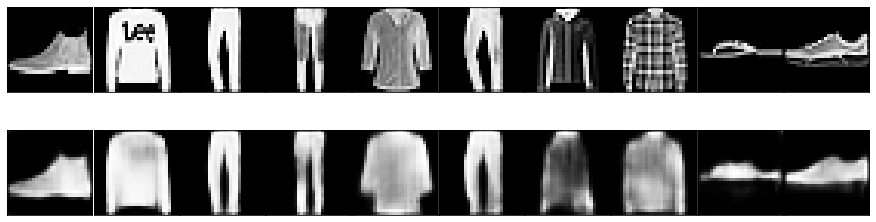

In [16]:
test_sample_images = test_images[:10]
test_sample_images = test_sample_images.reshape(-1, image_size, image_size, n_channels)
reconstructed_images = test_network(model_save_path, test_sample_images)
reconstructed_images = np.array(reconstructed_images).reshape(10,28,28,1)
plot_images(test_sample_images, reconstructed_images)

## Latent features (Encodings)  

In [0]:
def get_encodings(model_path, images, encoding_vector_length):
  with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, model_path)
    default_graph = tf.get_default_graph()
    inputs = default_graph.get_tensor_by_name('inputs:0')
    targets = default_graph.get_tensor_by_name('targets:0')
    
    iterator_init = default_graph.get_operation_by_name('init_iterator')
    encoded = default_graph.get_tensor_by_name('encodings:0')
    encoding_vectors =[]
    sess.run(iterator_init, feed_dict={
        inputs:images,
        targets:images
    })
    try:
      while True:
        encoding_vectors.append(sess.run(encoded))
    except tf.errors.OutOfRangeError:
      pass
    return np.array(encoding_vectors).reshape(-1, encoding_vector_length)

## Build the Annoy Index

In [0]:
encoding_vector_length = 128
annoy_file_name = 'fashion-mnist.annoy.index'
num_trees = 10

In [0]:
def build_annoy_index(encoding_dim, num_trees, annoy_index_file, encodings):
  ann = AnnoyIndex(encoding_dim)
  for index, encoding in enumerate(encodings):
    ann.add_item(index, encoding)
  ann.build(num_trees)
  ann.save(annoy_index_file)
  print("Created Annoy Index Successfully")
  

In [20]:
train_images = train_images.reshape(train_images.shape[0], image_size, image_size, n_channels)
encodings = get_encodings(model_save_path, train_images, encoding_vector_length)
build_annoy_index(encoding_vector_length, num_trees, annoy_file_name, encodings)

Created Annoy Index Successfully


## Get Similar Images

In [0]:
def get_similar_images(image, n_similar=10):
  encoding = get_encodings(model_save_path,image.reshape(-1, image_size, image_size,n_channels), encoding_vector_length)
  saved_ann = AnnoyIndex(encoding_vector_length)
  saved_ann.load(annoy_file_name)
  nn_indices = saved_ann.get_nns_by_vector(encoding[0], n_similar)
  print("Similar images are")
  for i, index in enumerate(nn_indices,1):
    image = train_images[index].reshape(28,28)
    plt.subplot(2,5,i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image, cmap='Greys_r')

Sample Image


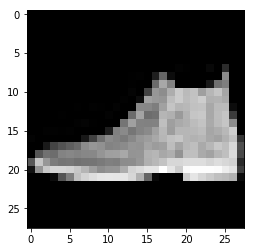

In [22]:
sample_image = test_images[0]
print("Sample Image")
plt.imshow(sample_image, cmap='Greys_r')

Similar images are


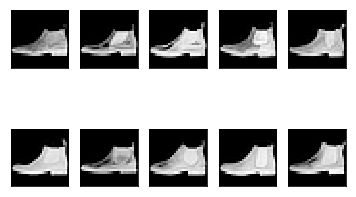

In [23]:
get_similar_images(sample_image)